# Decoding a quantum memory experiment

*Want to follow along? {nb-download}`Download this notebook.<decode.ipynb>`*

In this notebook we demonstrate all the steps required to decode a quantum error correction experiment. Specifically, we will be using data from a quantum memory experiment published by Google ([Google Quantum AI, _Nature 614, 676-681_, 2023](https://www.nature.com/articles/s41586-022-05434-1)) and use the Minimum Weight Perfect Matching decoder to obtain logical error probabilities for different experiment scenarios.

This notebook covers the following steps: 

- A short introduction to decoding 
- Preparation 
- The experiment 
- The decoding process 
- Using the experimental graph method 
- What’s next?

## A short introduction to decoding 

When performing error correction, we use multiple physical qubits to represent a single logical qubit, thereby introducing redundancy into the system. In order to understand what errors have occurred on the physical qubits, and how they might have affected our logical qubit state, we make measurements across combinations of physical qubits. These combinations are known as detectors. In the absence of errors, each detector should have a deterministic value. These detectors can therefore be used to learn about the errors that have occurred. This process is known as decoding, and is the job of a decoder. 

In general, solving the decoding problem optimally is very computationally intensive and thus decoders typically involve some level of approximation. Different decoders approach the problem differently, and may perform more or less well depending on the particular decoding problem. Even an optimal decoder will not be correct every time, as multiple different combinations of errors can lead to the same detector values. This is a problem if the different error combinations have different effects on the logical qubit. For example, a particular combination of errors may have caused a logical **X** error (flipping the logical `|0⟩` component to the logical `|1⟩` component and vice versa), but the decoder may decide a different combination of errors, which do not cause a logical **X** error but result in the same detector outcomes, instead happened. This is a logical error. 

In order for us to know with certainty that a logical error occurred, we need to know the intended state of the logical qubit. For example, if a logical qubit is measured to be in the `|1⟩` state but intended to be in the `|0⟩` state, we know that a logical **X** error occurred. Conversely, if we don’t know the intended state of the logical qubit then we cannot know whether a logical error occurred. This makes finding out whether or not a logical error occurred in a large fault-tolerant quantum computation challenging unless we have a way of verifying the output. However, in small experiments, such as those considered here, we typically know what the true logical state should be, and thus are able to determine whether a logical error has occurred. 

**In this notebook, we will be estimating logical error probabilities – that is, probabilities of logical errors occurring.** These are found by performing an experiment multiple times and calculating the proportion of the time a logical error occurred. The logical error probability depends on the properties of the quantum computer, the particular experiment that is run, and the decoder. These logical error probabilities are calculated using data from experiments that have been run on a quantum computer. This data is stored in a measurement data file. We also need to know what circuit was run in each experiment, in order to understand what measurement was performed to get each result. These are captured in the STIM circuit format. These circuits also specify the definitions of the detectors. 

## Preparation
### Perform all necessary imports

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import stim
from deltakit.explorer import analysis, Client
from deltakit.explorer.enums import DecoderType, DataFormat
from deltakit.explorer.types import (
    BinaryDataType,
    Decoder,
    Measurements,
    PhysicalNoiseModel
)
from tqdm import tqdm

Set `log_to_screen=True` if you want the library to log technical information to the screen:

In [2]:
log_to_screen = False

if log_to_screen:
    from deltakit.explorer import Logging

    Logging.set_log_to_console(True)
    Logging.set_log_level(Logging.INFO)

### Downloading data

For this notebook you will need to download experimental data. You may manually download it from [https://zenodo.org/records/6804040](https://zenodo.org/records/6804040), or run the following script:

In [3]:
! if [ ! -e "../../data/examples/google_qmem_experiment/input" ]; then ../../scripts/get_google_data.sh ../../data ; fi

### Set up server and data folder

In [4]:
client = Client.get_instance()
data_folder = Path("../..") / "data/examples"

## The Experiment

To demonstrate how Deltakit can be used to decode a quantum error correction experiment, we will use data from a quantum memory experiment published by Google ([Google Quantum AI, _Nature 614, 676-681_, 2023](https://www.nature.com/articles/s41586-022-05434-1)). The aim of the experiment is to preserve the state of a single logical qubit through time. A selection of the data is available in the examples data folder – the locations of the necessary input data are specified in the cell below.

The measurement file contains the measurement values (0s and 1s) for each measurement made in each run of the experiment. The STIM circuit file gives the specific gates that were run and also defines which combinations of measurements make up the detectors. The input STIM circuit is referred to as ideal because it does not contain noise.

An additional file is made use of here – a file containing sweep bit values. This file is used to vary the starting state in the experiment. This may not be part of the setup of other experiments – in such cases, the file can simply be omitted. 

In [5]:
experiment_basis = "Z"
experiment_folder = data_folder / f"google_qmem_experiment/input/surface_code_b{experiment_basis}_d3_r03_center_3_5/"
measurements_file = experiment_folder / "measurements.b8"
ideal_stim_circuit_file = experiment_folder / "circuit_ideal.stim"
sweep_file = experiment_folder / "sweep.b8"

### Noise model parameters

In order to perform decoding, the decoder needs to have a model of the possible errors that can occur on the device and their probabilities. This model enables the decoder to seek the most likely combination of errors that could cause the observed detector outcomes. Ideally, these parameters should match those of the quantum computer on which the experiment was run as closely as possible. Here, we have chosen some small number of parameters to describe the noise model, based on the physical parameters of the Google quantum computer.

The STIM circuit format can capture this noise. When we call the decoder in the next section, we will take the noise-free version of the STIM circuit, referred to as the ideal STIM circuit, and use the noise parameters to add noise channels in the appropriate locations. For example, `“p_1_qubit_gate_error”: 0.001` indicates that we wish to add depolarising noise of 0.1% after every one-qubit gate. 

In [ ]:
noise_model = PhysicalNoiseModel.get_superconducting_noise()
for _key, _value in noise_model.__dict__.items():
    print(f"{_key} = {_value}")

## The decoding process 

In addition to the experiment data and circuit specified in the previous section, a user has to choose a decoder and specify whether to use the experimental graph method or not. In this case we use the Minimum Weight Perfect Matching (MWPM) decoder, see the **User Guide** in the documentation for more details on available decoders. Within this section, we do not use the experimental graph method and thus set the parameter `use_experimental_graph` to `False`. 

In [7]:
decoder = Decoder(decoder_type=DecoderType.MWPM, use_experimental_graph=False)

### Perform decoding for a single data point 


The code below performs decoding for the experiment that was specified earlier in the notebook. The result of the decoding is two numbers: one is the total number of runs of the experiment decoded, and the other is the number of runs of the experiments decoded incorrectly (i.e. that caused a logical error). Additionally, a few intermediate files were generated during decoding – we will not consider them during this notebook; please see the [Noise analysis for a quantum memory experiment](noise_analysis.ipynb) example notebook to learn more about these files. 

To calculate the logical error probability, we take the ratio of fails to shots.

In [8]:
circuit = stim.Circuit.from_file(ideal_stim_circuit_file)
measurements = Measurements(
    data=measurements_file,
    data_format=DataFormat.B8,
    data_width=circuit.num_measurements,
)
sweep_bits = BinaryDataType(sweep_file, DataFormat.B8, circuit.num_sweep_bits)
decode_result = client.decode_measurements(
    measurements=measurements,
    decoder=decoder,
    ideal_stim_circuit=circuit,
    noise_model=noise_model,
    sweep_bits=sweep_bits,
)

## Perform Decoding for multiple values

We now repeat the decoding process for multiple experiments. Each experiment has a different number of rounds. 

### Prepare file names

In [9]:
experiment_folders = {}
stim_circuit_files, measurement_files, sweep_files = {}, {}, {}
all_rounds = list(range(1, 9, 2))
for num_rounds in all_rounds:
    experiment_folders[num_rounds] = data_folder / f"google_qmem_experiment/input/surface_code_b{experiment_basis}_d3_r{num_rounds:02}_center_3_5/"
    stim_circuit_files[num_rounds] = experiment_folders[num_rounds] / "circuit_ideal.stim"
    measurement_files[num_rounds] = experiment_folders[num_rounds] / "measurements.b8"
    sweep_files[num_rounds] = experiment_folders[num_rounds] / "sweep.b8"

### Decode multiple experiments

In [10]:
result = {}

for num_rounds in tqdm(all_rounds): 
    circuit = stim.Circuit.from_file(stim_circuit_files[num_rounds])
    measurements = Measurements(
        data=measurement_files[num_rounds],
        data_format=DataFormat.B8,
        data_width=circuit.num_measurements,
    )
    sweep_bits = BinaryDataType(
        sweep_files[num_rounds],
        DataFormat.B8,
        circuit.num_sweep_bits,
    )
    result[num_rounds] = client.decode_measurements(
        measurements=measurements,
        decoder=decoder,
        ideal_stim_circuit=circuit,
        noise_model=noise_model,
        sweep_bits=sweep_bits,
    )

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


### Plot decoding against rounds

Here, we plot the logical error probabilities for each experiment. From these, we can derive the logical error rate, a measure of the logical performance per round. 

Text(0, 0.5, 'Logical error probability')

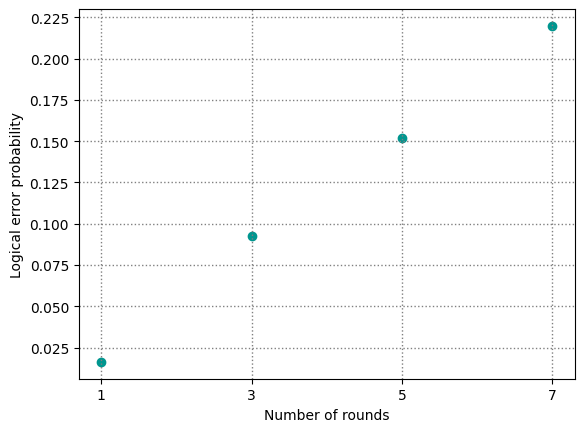

In [11]:
fails = [result[num_rounds].fails for num_rounds in all_rounds]
shots = [result[num_rounds].shots for num_rounds in all_rounds]
probs = [
    result[num_rounds].get_logical_error_probability()
    for num_rounds in all_rounds
]
plt.figure(1)
plt.scatter(all_rounds, probs,
         color="#00968f", marker="o")
plt.xticks(all_rounds)
plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xlabel("Number of rounds")
plt.ylabel("Logical error probability")

### Plot with error bars

Through the process in this notebook, we obtain an estimate of the logical error probability. The precision of this estimate will depend on the number of times we have repeated the experiment. To indicate the uncertainty in the estimate, we plot the results with error bars corresponding to one standard deviation on either side of the estimate. 

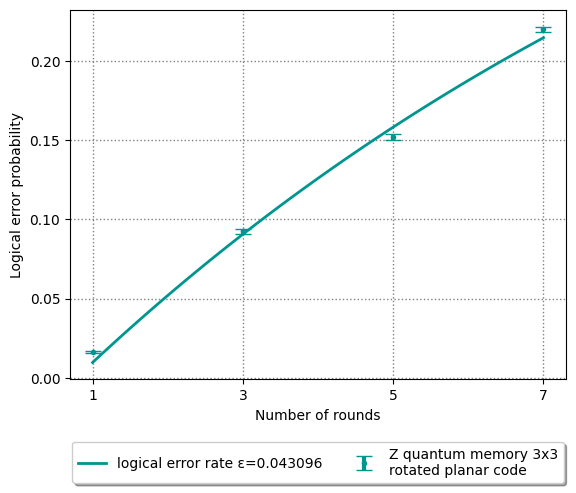

In [ ]:
eps, rounds_fit, probability_fit, y_error_bars = analysis.get_exp_fit(
    logical_fails_all_rounds=fails,
    shots_all_rounds=shots,
    all_rounds=all_rounds,
    interpolation_points=100,
)
plt.plot(rounds_fit, probability_fit,
         color="#00968f", lw=2,
         label=f"logical error rate ε={eps:6f}")
plt.errorbar(all_rounds, probs, y_error_bars,
         marker=".", mec="#00968f", mfc="#00968f", color="#00968f",
         capsize=6, capthick=1, elinewidth=3, ecolor="#00968f",
         label=f"{experiment_basis} quantum memory 3x3\nrotated planar code",
         linestyle="")
plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xticks(all_rounds)
plt.xlabel("Number of rounds")
plt.ylabel("Logical error probability")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.show()

## Using the experimental graph method

As explained above, the decoder needs a model of the noise that happens on the quantum computer. In practice, this could be difficult to obtain – for example, noise parameters may vary while the experiment is in progress. As a result, an alternative method was proposed whereby the model of the noise is derived directly from the experiment measurement outcomes. This is known as the experimental graph method. When using this method, we also set a lower bound for the noise parameters by passing the decoding method a new noise model given by `PhysicalNoiseModel.get_floor_superconducting_noise()` - this prevents error mechanisms obtained from the experimental graph method from having un-physically low probabilities.

In [13]:
exp_graph_result = {}
decoder.use_experimental_graph = True

for num_rounds in tqdm(all_rounds): 
    circuit = stim.Circuit.from_file(stim_circuit_files[num_rounds])
    measurements = Measurements(
        data=measurement_files[num_rounds],
        data_format=DataFormat.B8,
        data_width=circuit.num_measurements,
    )
    sweep_bits = BinaryDataType(
        sweep_files[num_rounds],
        DataFormat.B8,
        circuit.num_sweep_bits,
    )
    exp_graph_result[num_rounds] = client.decode_measurements(
        measurements=measurements,
        decoder=decoder,
        ideal_stim_circuit=circuit,
        noise_model=PhysicalNoiseModel.get_floor_superconducting_noise(),
        sweep_bits=sweep_bits,
    )

100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


### Plot comparison of decoding with vs. without experimental graph

We now plot the logical error probabilities calculated by performing decoding with the noise model above and with the experimental graph method. We can see that the experimental graph method gives better results (i.e. lower logical error probabilities) than the coarse noise model we defined. 

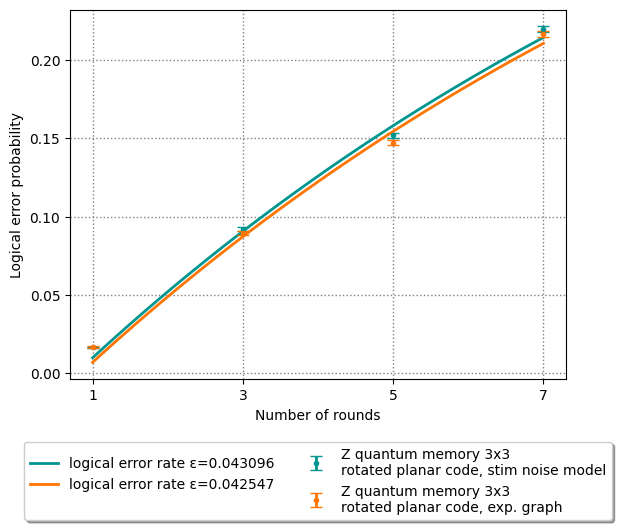

In [ ]:
# plot the noise model decoding results
plt.plot(rounds_fit, probability_fit,
         color="#00968f", lw=2,
         label=f"logical error rate ε={eps:6f}")
plt.errorbar(all_rounds, probs, y_error_bars,
         marker=".", mec="#00968f", mfc="#00968f", color="#00968f",
         capsize=4, capthick=1, elinewidth=2, ecolor="#00968f",
         label=f"{experiment_basis} quantum memory 3x3\nrotated planar code, stim noise model",
         linestyle="")

# calculate and plot the exp. graph decoding results
exp_fails = [exp_graph_result[r].fails for r in all_rounds]
exp_shots = [exp_graph_result[r].shots for r in all_rounds]
exp_probs = [
    exp_graph_result[r].get_logical_error_probability() 
    for r in all_rounds
]

exp_eps, exp_rounds_fit, exp_probability_fit, exp_y_error_bars = analysis.get_exp_fit(
    logical_fails_all_rounds=exp_fails,
    shots_all_rounds=exp_shots,
    all_rounds=all_rounds,
    interpolation_points=100,
)

plt.plot(exp_rounds_fit, exp_probability_fit,
         color="#ff7500", lw=2,
         label=f"logical error rate ε={exp_eps:6f}")
plt.errorbar(all_rounds, exp_probs, exp_y_error_bars,
         marker=".", mec="#ff7500", mfc="#ff7500", color="#ff7500",
         capsize=4, capthick=1, elinewidth=2, ecolor="#ff7500",
         label=f"{experiment_basis} quantum memory 3x3\nrotated planar code, exp. graph",
         linestyle="")

plt.xticks(all_rounds)
plt.grid(color="gray", linestyle=":", linewidth=1)
plt.xlabel("Number of rounds")
plt.ylabel("Logical error probability")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

## What's next?

In this notebook, we used experimental data from the Google quantum computer to calculate logical error probabilities.

To learn more about the intermediate files generated in the course of these calculations and use them to gain more insights into the performance of the device, please see the [Noise analysis for a quantum memory experiment](noise_analysis.ipynb) example notebook. 